# "FIFA21 EPL analysis"
> "Unsupervised learning - prediction of FIFA21 players' position"

- toc: True
- branch: master
- badges: true
- categories: ['Web scrap', 'Data Viz', 'ML']
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

Objective of this notebook:
* Apply webscrap by myself
* Visualise FIFA21 player data
* Unsupervised learning to predict players' position

Note book summary:
* Create python script (BeautifulSoup) to scrap FIFA21 EPL players data from https://sofifa.com/ 
* Clean data
* Gained information from the data
* Simplify position
* Train test split via stratified sampling
* Predict position => **90% accuracy and F1 score for the test set via SVM**
* Midfielders are the position that are hardest to predict

Inspired by this analysis from Kaggle: https://www.kaggle.com/younessennadj/fifa19-analytics-predict-position#4.Divide-the-data-to-train-and-test-datasets

# Import python module

In [2]:
# collapse
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs

import time
import re

from random import randrange

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Webscrap FIFA21 EPL players' stats

First, check if you can webscrap. sofifa.com indicate you can webscrap through their robots.txt

Webscrap procedure:
* Search prem players in Fifa21
* Results are stored in table, 60 per page. up to 600
* open each pages, grab the link to pages for individual players

Note: scrap responsibly. Add a random 2-6 seconds delay in between access to webpages

## Grab list of EPL players

In [3]:
# collapse
links = []

for x in range(1):
    
    # make a search and scrap the webpage --------------------------------------------------
    base_url = 'https://sofifa.com/players?type=all&lg%5B%5D=13'
    
    
    if x > 0:
        add_url ='&offset='+str(x*60)
    else:
        add_url=''

    r = requests.get(base_url+add_url)
    
    # call the soup function to make the html readable --------------------------------------
    webpage = bs(r.content)
    table = webpage.find('table')
    rows = table.find_all('tr')
    
    for row in rows[1::]:
        link = row.find_all("a",{"class":"tooltip"})[0]
        links.append(link['href'])
    
    # print progress on scrapping link
    print("Page",x,"done")
    
    #Be sure to pause
    time.sleep(randrange(2,6))

Page 0 done


Number of players in EPL:

In [4]:
# collapse
len(links)

60

The top 10 players, sorted by overall rating:

In [5]:
# collapse
links[:10]

['/player/192985/kevin-de-bruyne/210012/',
 '/player/212831/alisson-ramses-becker/210012/',
 '/player/209331/mohamed-salah/210012/',
 '/player/208722/sadio-mane/210012/',
 '/player/203376/virgil-van-dijk/210012/',
 '/player/153079/sergio-aguero/210012/',
 '/player/202126/harry-kane/210012/',
 '/player/215914/ngolo-kante/210012/',
 '/player/210257/ederson-santana-de-moraes/210012/',
 '/player/202652/raheem-sterling/210012/']

Ok, we have 644 players registered in EPL in the FIFA21 game. That is 32 players per club which is about right

## Scrap individual player stats

Note: I have scrapped them before using the same function below. For for this demo, I will only scrap the first 10 players

In [6]:
links3 = links[:10]

Players to scrap (show first 5):

In [7]:
# collapse
links3[:5]

['/player/192985/kevin-de-bruyne/210012/',
 '/player/212831/alisson-ramses-becker/210012/',
 '/player/209331/mohamed-salah/210012/',
 '/player/208722/sadio-mane/210012/',
 '/player/203376/virgil-van-dijk/210012/']

Use function to scrap

In [8]:
# collapse
list_stats_top10 = []

def player_name(weblink):
    return weblink.find('h1').text

def nat(weblink):
    return weblink.find('div',{"class":"meta bp3-text-overflow-ellipsis"}).a['title']
    
def dob_wh(weblink):
    stuff = weblink.find('div',{"class":"meta bp3-text-overflow-ellipsis"}).text
    temp = stuff.split("(")[1]
    dob = temp.split(")")[0]
    temp2 = temp.split(")")[1].split(" ")
    height = temp2[1]
    weight = temp2[2]
    return dob, height, weight

def club_info(weblink):
    club = weblink.find(text = re.compile('Player Specialities')).parent.findNext('h5').text
    jersey = weblink.find(text = re.compile('Jersey Number')).next
    c_valid = weblink.find(text = re.compile('Contract Valid Until')).next
    c_value = weblink.find('section',{"class":"card spacing"}).find(text = re.compile('Value')).previous.previous
    wage = weblink.find('section',{"class":"card spacing"}).find(text = re.compile('Wage')).previous.previous
    return club, jersey, c_valid, c_value, wage

def player_stats(weblink):
    best_pos = weblink.find(text = re.compile('Best Position')).next.text
    best_rating = weblink.find(text = re.compile('Best Overall Rating')).next.text
    return best_pos, best_rating
    
def player_stats_detail(weblink):
    
    # Attacking stats
    temp = weblink.find(text = re.compile('Attacking')).parent.parent.find_all("li")
    keys = ['Crossing','Finishing','Heading Accuracy','Short Passing','Volleys']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text
    
    # skill stats
    temp = weblink.find(text = re.compile('Attacking')).parent.parent.parent.find_next_sibling("div").find_all("li")
    keys = ['Dribbling','Curve','FK Accuracy','Long Passing','Ball Control']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text
    
    # movement stats
    temp = weblink.find(text = re.compile('Movement')).parent.parent.find_all("li")
    keys = ['Acceleration','Spring Speed','Agility','Reactions','Balance']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text

    # power stats
    temp = weblink.find(text = re.compile('Power')).parent.parent.find_all("li")
    keys = ['Shot Power','Jumping','Stamina','Strength','Long Shots']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text
    
    
    # mentality stats
    temp = weblink.find(text = re.compile('Mentality')).parent.parent.find_all("li")
    keys = ['Aggression','Interceptions','Positioning','Vision','Penalties','Composure']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text
    
    # defending stats
    temp = weblink.find(text = re.compile('Defending')).parent.parent.find_all("li")
    keys = ['Defensive Awareness','Standing Tackle','Sliding Tackle']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text
    
    # goalkeeping stats
    temp = weblink.find(text = re.compile('Goalkeeping')).parent.parent.find_all("li")
    keys = ['GK Diving','GK Handling','GK Kicking','GK Positioning','GK Reflexes']
    for index,attrs in enumerate(temp):
        temp2 = attrs.find_all('span')
        stats[keys[index]] = temp2[0].text
    
    # traits stats
    try:
        temp = weblink.find(text = re.compile('Traits')).parent.parent.find_all("li")
        for attrs in temp:
            if 'Traits' in stats:
                stats['Traits'].append(attrs.text)
            else:
                stats['Traits'] = [attrs.text]
    except:
        stats['Traits'] = None
    
for index,link in enumerate(links3):
    # make a search and scrap the webpage --------------------------------------------------
    base_url = 'https://sofifa.com/'
    add_url = link
    r = requests.get(base_url+add_url)
    weblink = bs(r.content)
    
    stats={}
    
    # get player name
    name = player_name(weblink)
    stats['Player_name'] = name
    
    # get nationality
    nationality = nat(weblink)
    stats['Nationality'] = nationality
    
    # get dob, weight, height
    dob, height, weight = dob_wh(weblink)
    stats['dob'] = dob
    stats['height'] = height
    stats['weight'] = weight
    
    # get club info
    club, jersey, c_valid, c_value, wage = club_info(weblink)
    stats['club'] = club
    stats['jersey'] = jersey
    stats['c_valid'] = c_valid
    stats['c_value'] = c_value
    stats['wage'] = wage
    
    # add general player stats
    pos, rating = player_stats(weblink)
    stats['pos'] = pos
    stats['rating'] = rating
    
    # add player stats detail
    player_stats_detail(weblink)
    
    
    # print progress --------------------------
    list_stats_top10.append(stats)
    
    if index % 10 ==0:
        print(index)
    
    #Be sure to pause between accessing pages
    time.sleep(randrange(2,6))
    

0


## Save JSON data of FIFA21 EPL players

In [9]:
# collapse
import json

def save_data(title,data):
    with open(title, 'w', encoding ='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent = 2)
    
def load_data(title):
    with open(title, encoding ='utf-8') as f:
        return json.load(f)

In [10]:
#save_data('FIFA21_EPL.json', list_stats)
#save_data('FIFA21_EPL_top10.json', list_stats_top10)

## Load data for later use

In [13]:
# collapse
import os
os.chdir("C:/Users/Riyan Aditya/Desktop/ML_learning/Project6_EPL_20192020")
FIFA21_data = load_data('FIFA21_EPL.json')

Lets see the first data, Kevin De Bruyne

In [14]:
FIFA21_data[0]

{'Player_name': 'K. De Bruyne',
 'Nationality': 'Belgium',
 'dob': 'Jun 28, 1991',
 'height': '5\'11"',
 'weight': '154lbs',
 'club': 'Manchester City',
 'jersey': '17',
 'c_valid': '2023',
 'c_value': '€129M',
 'wage': '€370K',
 'pos': 'CAM',
 'rating': '91',
 'Crossing': '94',
 'Finishing': '82',
 'Heading Accuracy': '55',
 'Short Passing': '94',
 'Volleys': '82',
 'Dribbling': '88',
 'Curve': '85',
 'FK Accuracy': '83',
 'Long Passing': '93',
 'Ball Control': '92',
 'Acceleration': '77',
 'Spring Speed': '76',
 'Agility': '78',
 'Reactions': '91',
 'Balance': '76',
 'Shot Power': '91',
 'Jumping': '63',
 'Stamina': '89',
 'Strength': '74',
 'Long Shots': '91',
 'Aggression': '76',
 'Interceptions': '66',
 'Positioning': '88',
 'Vision': '94',
 'Penalties': '84',
 'Composure': '91',
 'Defensive Awareness': '68',
 'Standing Tackle': '65',
 'Sliding Tackle': '53',
 'GK Diving': '15',
 'GK Handling': '13',
 'GK Kicking': '5',
 'GK Positioning': '10',
 'GK Reflexes': '13',
 'Traits': ['I

# Data cleaning

In [15]:
df = pd.DataFrame(FIFA21_data)

Few things to do:
* Everything is string. Convert to numeric when needed to be, especially the individual stats
* Convert DOB to datetime
* Convert height and weight to the SI unit
* Convert value and wages to the right unit (eg: no M and no K)
* What to do with traits in players? Perhaps ignore for now

## Traits

First, lets look at the traits
* How many unique traits are there?
* Proportion of players that have traits?
* Is it worth keeping?

**Players with no traits**:

In [16]:
# collapse
df['Traits'].isnull().values.ravel().sum()

197

199 from 644 players (~30%) do not have any traits

Top 5 players that have no traits:

In [17]:
# collapse
df[df['Traits'].isnull()][:5].Player_name

6        N. Kanté
32          Rodri
94     D. Sánchez
115      N. Matić
124      J. Evans
Name: Player_name, dtype: object

Wow. Kante doesnt have any traits? This could be a mistake from Fifa21 database

**Unique traits**:

In [18]:
# collapse
df.Traits.explode().unique() 

array(['Injury Prone', 'Leadership', 'Early Crosser', 'Long Passer (AI)',
       'Long Shot Taker (AI)', 'Playmaker (AI)', 'Outside Foot Shot',
       'GK Long Throw', 'Rushes Out Of Goal', 'Finesse Shot',
       'Speed Dribbler (AI)', 'Chip Shot (AI)', 'Flair', 'Solid Player',
       'Power Header', None, 'Comes For Crosses', 'Team Player',
       'Dives Into Tackles (AI)', 'Technical Dribbler (AI)',
       'Cautious With Crosses', 'Saves with Feet', 'Long Throw-in',
       'Power Free-Kick', 'Giant Throw-in', nan], dtype=object)

In [19]:
# collapse
print("number of unique traits :",len(df.Traits.explode().unique()))

number of unique traits : 26


26 unique traits. Probably too long if I expand the column similar to how a OHE works

**Is it worth keeping?**

Probably not. Remove them for now

In [20]:
# collapse
df2 = df.copy()
df2 = df2.drop(labels='Traits', axis=1)

In [21]:
# collapse
df2.columns

Index(['Player_name', 'Nationality', 'dob', 'height', 'weight', 'club',
       'jersey', 'c_valid', 'c_value', 'wage', 'pos', 'rating', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Acceleration', 'Spring Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes'],
      dtype='object')

In [22]:
# collapse
# fix mistake with column name
df2.rename(columns={'Spring Speed':'Sprint Speed'}, inplace=True)

## Convert to numeric

*DOB to datetime*

In [23]:
# collapse
df2['dob'] = pd.to_datetime(df2['dob'])

In [24]:
df2.dob.dtype

dtype('<M8[ns]')

*Height to numeric & SI*

In [25]:
# collapse
def height_conversion(ht):
    # current format is x'x"
    ht2 = ht.split("'")
    ft = float(ht2[0])
    inc = float(ht2[1].replace("\"",""))   # " is a special character
    return round(((12*ft)+inc)*2.54,0)

df2['height'] = df2['height'].apply(lambda x:height_conversion(x))

In [26]:
# collapse
df2.height.dtype

dtype('float64')

*Weight to numeric & SI*

In [27]:
# collapse
def weight_conversion(wt):
    # current format is xxxlbs
    wt2 = wt.split('lbs')
    return round(float(wt2[0])*0.453592,0)

df2['weight'] = df2['weight'].apply(lambda x:weight_conversion(x))

In [28]:
# collapse
df2.weight.dtype

dtype('float64')

*Contract value and wage to numeric*

In [29]:
# collapse
value_dict = {"K":1000, "M":1000000 }

def money_conversion(money):
    # current format is €xxxxK
    money = money.replace('€','')
    
    if money[-1] in value_dict:
        num, values = money[:-1], money[-1]
        return (float(num)* value_dict[values])

df2['c_value'] = df2['c_value'].apply(lambda x:money_conversion(x))
df2['wage'] = df2['wage'].apply(lambda x:money_conversion(x))

In [30]:
# collapse
df2.c_value.dtype,  df2.wage.dtype

(dtype('float64'), dtype('float64'))

*Convert jersey, rating and individual stats attributes to numeric*

In [31]:
# collapse
df2['jersey'] = pd.to_numeric(df2['jersey'], errors='coerce')
df2['rating'] = pd.to_numeric(df2['rating'], errors='coerce')

for col in  df2.columns[12::]:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

In [32]:
# collapse
df3 = df2.copy()

# Top players of Fifa21 

**Top rated players from each club**

Note that there can be multiple top rated players per club

In [33]:
# collapse
idx = df3.groupby(['club'])['rating'].transform(max) == df3['rating']
top_rated = df3[idx][['club','Player_name','pos','rating']]
top_rated.sort_values('club')

,club,Player_name,pos,rating
11,Arsenal,P. Aubameyang,ST,87
105,Aston Villa,J. Grealish,CAM,83
194,Brighton & Hove Albion,L. Trossard,CAM,80
129,Brighton & Hove Albion,M. Ryan,GK,80
193,Brighton & Hove Albion,L. Dunk,CB,80
77,Burnley,N. Pope,GK,82
6,Chelsea,N. Kanté,CDM,88
63,Crystal Palace,W. Zaha,CF,83
51,Everton,Allan,CDM,85
76,Fulham,A. Areola,GK,82


**Top rated players per pos**

These positions are based on what FIFA21 recommend as "Best Position"

In [34]:
# collapse
idx = df3.groupby(['pos'])['rating'].transform(max) == df3['rating']
top_rated = df3[idx][['pos','club','Player_name','rating']]

# create custom sort so this makes positional sense
custom_dict = {'GK':0, 'CB':1, 'LB':2, 'RB':3, 'LWB':4, 'RWB':5, 'CDM':6, 'CM':7, 'CAM':8, 'RM':9, 'LM':10,
              'RW':11, 'LW':12, 'CF':13, 'ST':14}
top_rated['rank'] = top_rated['pos'].map(custom_dict)
top_pos = top_rated.sort_values('rank')
top_pos.drop(labels=['rank'], axis=1)

,pos,club,Player_name,rating
1,GK,Liverpool,Alisson,90
4,CB,Liverpool,V. van Dijk,90
13,LB,Liverpool,A. Robertson,87
12,RB,Liverpool,T. Alexander-Arnold,87
89,LWB,Manchester City,B. Mendy,82
54,RWB,Manchester City,João Cancelo,84
6,CDM,Chelsea,N. Kanté,88
23,CM,Manchester United,P. Pogba,86
50,CM,Chelsea,M. Kovačić,86
0,CAM,Manchester City,K. De Bruyne,91


Some weird result here. Right forward maybe, but I would not put Rasford as a Right milfielder

**Top rated players per original country**

Unique nationalities of Prem players

In [35]:
# Collapse
df3.Nationality.unique().shape

(60,)

List of top players per nationality of origin:

In [36]:
# collapse
idx = df3.groupby(['Nationality'])['rating'].transform(max) == df3['rating']
top_rated = df3[idx][['Nationality','club','Player_name','pos','rating']]
top_rated.sort_values('Nationality')

,Nationality,club,Player_name,pos,rating
33,Algeria,Manchester City,R. Mahrez,RW,85
5,Argentina,Manchester City,S. Agüero,ST,89
129,Australia,Brighton & Hove Albion,M. Ryan,GK,80
390,Austria,Leicester City,C. Fuchs,CDM,74
0,Belgium,Manchester City,K. De Bruyne,CAM,91
...,...,...,...,...,...
112,Ukraine,Manchester City,O. Zinchenko,CM,81
80,United States,Chelsea,C. Pulisic,CAM,82
43,Uruguay,Manchester United,E. Cavani,ST,84
60,Wales,Tottenham Hotspur,G. Bale,RW,83


**Top player based on some stats**

Best crosser

In [37]:
# collapse
df3[['Player_name','club','pos','Crossing']].loc[df3['Crossing'].idxmax()]

Player_name       K. De Bruyne
club           Manchester City
pos                        CAM
Crossing                    94
Name: 0, dtype: object

Best short passer

In [38]:
# collapse
df3[['Player_name','club','pos','Short Passing']].loc[df3['Short Passing'].idxmax()]

Player_name         K. De Bruyne
club             Manchester City
pos                          CAM
Short Passing                 94
Name: 0, dtype: object

Best long passer

In [39]:
# collapse
df3[['Player_name','club','pos','Long Passing']].loc[df3['Long Passing'].idxmax()]

Player_name        K. De Bruyne
club            Manchester City
pos                         CAM
Long Passing                 93
Name: 0, dtype: object

Best header

In [40]:
# collapse
df3[['Player_name','club','pos','Heading Accuracy']].loc[df3['Heading Accuracy'].idxmax()]

Player_name         O. Giroud
club                  Chelsea
pos                        ST
Heading Accuracy           90
Name: 130, dtype: object

Best finisher

In [41]:
# collapse
df3[['Player_name','club','pos','Finishing']].loc[df3['Finishing'].idxmax()]

Player_name          S. Agüero
club           Manchester City
pos                         ST
Finishing                   94
Name: 5, dtype: object

Best FK taker

In [42]:
# collapse
df3[['Player_name','club','pos','FK Accuracy']].loc[df3['FK Accuracy'].idxmax()]

Player_name    J. Ward-Prowse
club              Southampton
pos                        CM
FK Accuracy                91
Name: 145, dtype: object

Best PK taker

In [43]:
# collapse
df3[['Player_name','club','pos','Penalties']].loc[df3['Penalties'].idxmax()]

Player_name                 R. Jiménez
club           Wolverhampton Wanderers
pos                                 ST
Penalties                           92
Name: 47, dtype: object

Best volleyer

In [44]:
# collapse
df3[['Player_name','club','pos','Volleys']].loc[df3['Volleys'].idxmax()]

Player_name    J. Rodríguez
club                Everton
pos                     CAM
Volleys                  90
Name: 67, dtype: object

Highest shot power

In [45]:
# collapse
df3[['Player_name','club','pos','Shot Power']].loc[df3['Shot Power'].idxmax()]

Player_name       K. De Bruyne
club           Manchester City
pos                        CAM
Shot Power                  91
Name: 0, dtype: object

Speed merchant and acceleration

In [46]:
# collapse
df3[['Player_name','club','pos','Sprint Speed']].loc[df3['Sprint Speed'].idxmax()]

Player_name                Adama Traoré
club            Wolverhampton Wanderers
pos                                  RM
Sprint Speed                         96
Name: 155, dtype: object

In [47]:
# collapse
df3[['Player_name','club','pos','Acceleration']].loc[df3['Acceleration'].idxmax()]

Player_name                Adama Traoré
club            Wolverhampton Wanderers
pos                                  RM
Acceleration                         97
Name: 155, dtype: object

Dribbler

In [48]:
# collapse
df3[['Player_name','club','pos','Dribbling']].loc[df3['Dribbling'].idxmax()]

Player_name     Bernardo Silva
club           Manchester City
pos                         RW
Dribbling                   92
Name: 17, dtype: object

In [49]:
# collapse
df3[['Player_name','club','pos','Ball Control']].loc[df3['Ball Control'].idxmax()]

Player_name        K. De Bruyne
club            Manchester City
pos                         CAM
Ball Control                 92
Name: 0, dtype: object

Best stamina

In [50]:
# collapse
df3[['Player_name','club','pos','Stamina']].loc[df3['Stamina'].idxmax()]

Player_name    N. Kanté
club            Chelsea
pos                 CDM
Stamina              96
Name: 6, dtype: object

Best strength

In [51]:
# collapse
df3[['Player_name','club','pos','Strength']].loc[df3['Strength'].idxmax()]

Player_name                    W. Boly
club           Wolverhampton Wanderers
pos                                 CB
Strength                            93
Name: 126, dtype: object

Best positioning

In [52]:
# collapse
df3[['Player_name','club','pos','Positioning']].loc[df3['Positioning'].idxmax()]

Player_name          S. Agüero
club           Manchester City
pos                         ST
Positioning                 94
Name: 5, dtype: object

Best vision

In [53]:
# collapse
df3[['Player_name','club','pos','Vision']].loc[df3['Vision'].idxmax()]

Player_name       K. De Bruyne
club           Manchester City
pos                        CAM
Vision                      94
Name: 0, dtype: object

Best composure

In [54]:
# collapse
df3[['Player_name','club','pos','Composure']].loc[df3['Composure'].idxmax()]

Player_name       K. De Bruyne
club           Manchester City
pos                        CAM
Composure                   91
Name: 0, dtype: object

Best defensive awareness

In [55]:
# collapse
df3[['Player_name','club','pos','Defensive Awareness']].loc[df3['Defensive Awareness'].idxmax()]

Player_name            V. van Dijk
club                     Liverpool
pos                             CB
Defensive Awareness             93
Name: 4, dtype: object

Interceptions

In [56]:
# collapse
df3[['Player_name','club','pos','Interceptions']].loc[df3['Interceptions'].idxmax()]

Player_name      N. Kanté
club              Chelsea
pos                   CDM
Interceptions          91
Name: 6, dtype: object

Best sliding tackle

In [57]:
# collapse
df3[['Player_name','club','pos','Sliding Tackle']].loc[df3['Sliding Tackle'].idxmax()]

Player_name          A. Wan-Bissaka
club              Manchester United
pos                              RB
Sliding Tackle                   90
Name: 57, dtype: object

Best GK reflexes

In [58]:
# collapse
df3[['Player_name','club','pos','GK Reflexes']].loc[df3['GK Reflexes'].idxmax()]

Player_name            H. Lloris
club           Tottenham Hotspur
pos                           GK
GK Reflexes                   90
Name: 19, dtype: object

Best GK kicking

In [59]:
# collapse
df3[['Player_name','club','pos','GK Kicking']].loc[df3['GK Kicking'].idxmax()]

Player_name            Ederson
club           Manchester City
pos                         GK
GK Kicking                  93
Name: 7, dtype: object

Tallest player (in cm)

In [60]:
# collapse
df3[['Player_name','club','pos','height']].loc[df3['height'].idxmax()]

Player_name    N. Pope
club           Burnley
pos                 GK
height             201
Name: 77, dtype: object

Heaviest player (kg)

In [61]:
# collapse
df3[['Player_name','club','pos','weight']].loc[df3['weight'].idxmax()]

Player_name         W. Morgan
club           Leicester City
pos                        CB
weight                    101
Name: 389, dtype: object

**Top player based on wages and salaries**

Highest wages

In [62]:
# collapse
df3[['Player_name','club','pos','wage']].loc[df3['wage'].idxmax()]

Player_name       K. De Bruyne
club           Manchester City
pos                        CAM
wage                    370000
Name: 0, dtype: object

Highest contract values

In [63]:
# collapse
df3[['Player_name','club','pos','c_value']].loc[df3['c_value'].idxmax()]

Player_name       K. De Bruyne
club           Manchester City
pos                        CAM
c_value               1.29e+08
Name: 0, dtype: object

**Top earner per club**

In [64]:
# collapse
idx = df3.groupby(['club'])['wage'].transform(max) == df3['wage']
top_rated = df3[idx][['club','Player_name','pos','rating','wage']]
top_rated.sort_values('club')

,club,Player_name,pos,rating,wage
11,Arsenal,P. Aubameyang,ST,87,170000.0
165,Aston Villa,R. Barkley,CAM,81,81000.0
194,Brighton & Hove Albion,L. Trossard,CAM,80,56000.0
193,Brighton & Hove Albion,L. Dunk,CB,80,56000.0
192,Burnley,C. Wood,ST,78,63000.0
6,Chelsea,N. Kanté,CDM,88,190000.0
63,Crystal Palace,W. Zaha,CF,83,89000.0
51,Everton,Allan,CDM,85,115000.0
226,Fulham,A. Mitrović,ST,79,90000.0
68,Leeds United,Rodrigo,ST,82,140000.0


**Total wages per club**

In [65]:
# collapse
grouped = df3.groupby('club')['wage'].sum().reset_index()
grouped.sort_values('wage', ascending=False)


,club,wage
11,Manchester City,3552000.0
12,Manchester United,2984000.0
10,Liverpool,2964000.0
16,Tottenham Hotspur,2503000.0
4,Chelsea,2371000.0
0,Arsenal,2116000.0
6,Everton,1835000.0
9,Leicester City,1817000.0
7,Fulham,1642000.0
8,Leeds United,1375000.0


I am not sure the wages in FIFA21 reflect the real wages of these players

# Feature engineering

We have 16 different positions. We need to simplify this.

Let's simplify those to the 4 traditional positions: Goalkeeper, Defender, Midfielder, Forward. For simplicity:
* GK: GK
* DF: CB, LB, RB, LWB, RWB
* MF: CDM, CM, CAM, RM, LM,  
* FW: RW, LW, CF, ST

## Simplify position

In [120]:
# collapse
def repos(pos):
    if pos == 'GK':
        return 'GK'
    elif pos[-1] == 'B':
        return 'DF'
    elif pos[-1] == 'M':
        return 'MF'
    else:
        return 'FW'

df3['pos2'] = df3.apply(lambda x: repos(x['pos']), axis=1)
        

In [121]:
# collapse
pos_count = df3['pos2'].value_counts()
pos_count

MF    240
DF    232
FW    104
GK     67
Name: pos2, dtype: int64

In [136]:
# collapse
import plotly.express as px
from IPython.display import HTML

cat_order = ['GK','DF','MF','FW']
fig = px.bar(pos_count.reindex(cat_order))
fig.update_layout(yaxis_title="Count")
fig.update_layout(xaxis_title="Position")
fig.update_layout(showlegend=False)
#fig.show()
HTML(fig.to_html(include_plotlyjs='cdn'))

## Plot of variables vs simpler position

**wage, rating per position**

In [143]:
# collapse
fig2 = px.scatter(df3, x="rating", y="wage", color="pos2", hover_data=['Player_name'])
HTML(fig2.to_html(include_plotlyjs='cdn'))

Interesting trend here. Seems like FW tend to be the expensive one, while MF are cheap

**Rating vs position**

In [144]:
# collapse
df3['pos2'] = pd.Categorical(df3['pos2'], ['GK','DF','MF','FW'])

fig3 = px.box(df3.sort_values("pos2"), x="pos2", y="rating", color = 'pos2', points="all", hover_data=['Player_name'])
fig3.update_layout(xaxis_title="Position")
fig3.update_layout(showlegend=False)
HTML(fig3.to_html(include_plotlyjs='cdn'))

Every position have players from 55 to 90s rating

**Wage vs position**

In [145]:
# collapse
fig4 = px.box(df3.sort_values("pos2"), x="pos2", y="wage", color = 'pos2', points="all", hover_data=['Player_name'])
fig4.update_layout(xaxis_title="Position")
fig4.update_layout(showlegend=False)
HTML(fig4.to_html(include_plotlyjs='cdn'))

KDB is an outlier in term of his FIFA21 salary

In [126]:
#
pd.pivot_table(df3, index = 'pos2', values = 'wage')

,wage
pos2,
GK,42522.388060
DF,47622.807018
MF,53268.907563
FW,66365.384615


Forward gets higher wages. Make sense. Goalscoring attribute is a premium

## Correlation map

In [127]:
# collapse
df4 = df3.copy()
df4 = df4[['pos2','height', 'weight','c_value', 'wage', 'rating', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes']]
df4.shape

(643, 40)

In [128]:
import seaborn as sns

<AxesSubplot:>

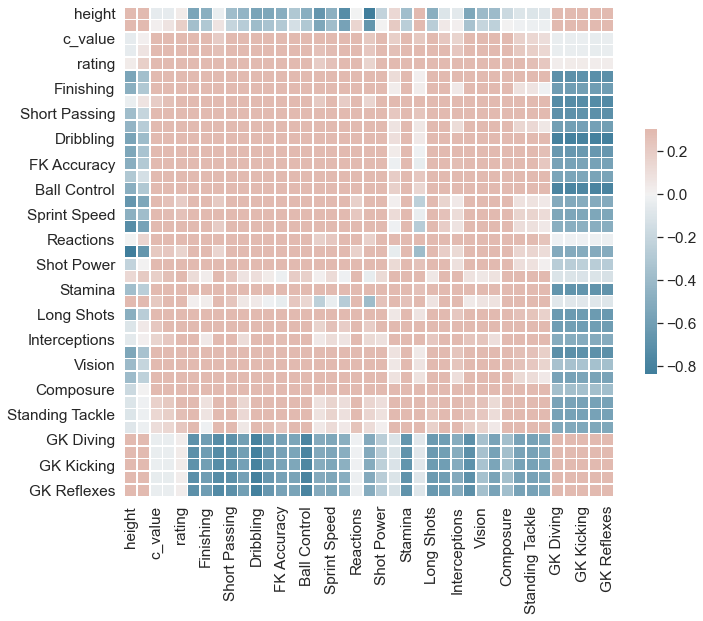

In [129]:
# collapse
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

corr = df4.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Some insights:
* Contract value and wages strongly correlated with attacking attributes => attakeer tends to have higher wages
* Interesting how height and weight tend to be correlated with Goalkeeping stats. Perhaps Goalie tends to be taller and heavier
* A lot of individual stats attributes seem to be correlated to each other

Perhaps, instead of predicting positions through 30+ different attributes, we can simplify this to the 6 attributes that FIFA Ultimate team use. These stats are the following:
* Pace
* Shooting 
* Passing
* Dribbling
* Defending
* Physical
* Goalkeeping

Based on: https://www.fifauteam.com/fifa-20-attributes-guide/


They are a combination based on several attributes. For example, shooting is made up of: finishing, long sots, penalties, positioning, shot power, volleys. These stats are weighted, but *for simplicity I will just average them.*

Note that Keepers usually have their own attributes, but I am going to make up keeping attributes which are simply the average of all the keepers attributes here. 

## Simplify stats

In [130]:
# collapse
df4['pace'] = df4.loc[:,['Acceleration','Sprint Speed'] ].mean(axis=1)
df4['shooting'] = df4.loc[:,['Finishing','Long shots','Penalties','Positioning','Shot Power','Volleys']].mean(axis=1)
df4['passing'] = df4.loc[:,['Crossing','Curve','FK Accuracy','Long Passing','Short Passing','Vision']].mean(axis=1)
df4['dribbling'] = df4.loc[:,['Agility','Balance','Ball Control','Composure','Dribbling','Reactions']].mean(axis=1)
df4['defending'] = df4.loc[:,['Heading Accuracy','Interceptions','Defensive Awareness','Sliding Tackle','Standing Tackle']].mean(axis=1)
df4['physical'] = df4.loc[:,['Aggression','Jumping','Stamina','Strength']].mean(axis=1)
df4['goalkeeping'] = df4.loc[:,['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning','GK Reflexes']].mean(axis=1)



C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



And again remove unnecessary column

In [131]:
# collapse
df5 = df4[['pos2', 'height', 'weight', 'c_value', 'wage', 'rating', 
           'pace', 'shooting', 'passing', 'dribbling', 'defending','physical', 'goalkeeping']]

<AxesSubplot:>

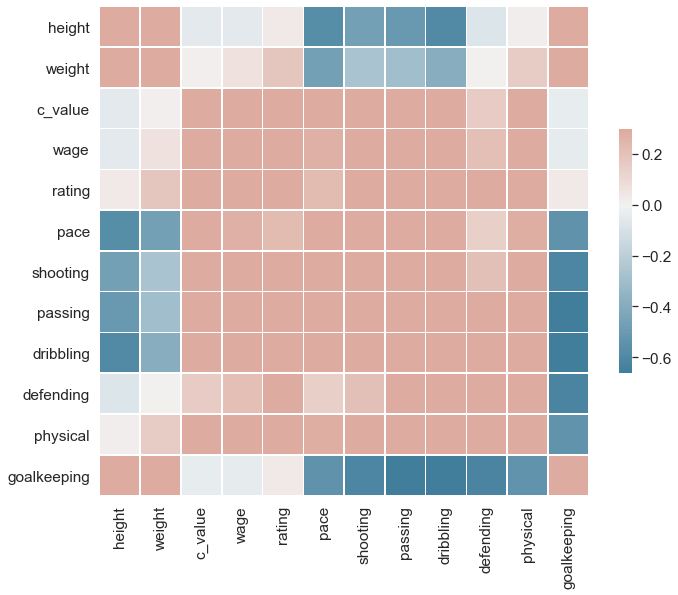

In [132]:
# collapse
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

corr = df5.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [133]:
corr['rating'].sort_values(ascending=False)

rating         1.000000
wage           0.792763
c_value        0.690792
dribbling      0.558178
physical       0.557454
passing        0.508782
shooting       0.420499
defending      0.308034
pace           0.227797
weight         0.182961
height         0.034694
goalkeeping    0.031497
Name: rating, dtype: float64

In [146]:
# collapse

fig5 = px.scatter(df5, x="shooting", y="passing", color="pos2", width = 600, height = 600)
HTML(fig5.to_html(include_plotlyjs='cdn'))

This looks promising for unsupervised learning per position

## Data cleaning

Remove NAN in wages

There are 7 players with no info on wages. *They will be removed*

In [135]:
# collapse
df5 = df5[df5['wage'].notna()]